## Dataset import

In [1]:
import tensorflow as tf
import os
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
from flax import linen as nn  # Linen API

from galsim_jax.dif_models import AutoencoderKLModule
from galsim_jax.utils import load_checkpoint
from galsim_jax.convolution import convolve_kpsf

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = str('0')
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-12.1"
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

# Checking for GPU access
print("Device: {}".format(xla_bridge.get_backend().platform))

# Checking the GPU available
gpus = jax.devices("gpu")
print("Number of avaliable devices : {}".format(len(gpus)))

# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type="GPU")

2023-09-13 15:33:21.501901: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-13 15:33:21.549838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 15:33:22.359999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Device: gpu
Number of avaliable devices : 1


In [2]:
import tensorflow_datasets as tfds
from galsim_jax.datasets import cosmos
import numpy as np
from astropy.stats import mad_std

In [3]:
# Loading the dataset and transforming it to NumPy Arrays
train_dset, info = tfds.load(name='Cosmos/25.2', with_info=True, split="train")

# What's in our dataset:
# info

def input_fn(mode="train", batch_size=128):
    """
    mode: 'train' or 'test'
    """

    def preprocess_image(data):
        # Reshape 'psf' and 'image' to (128, 128, 1)
        data["kpsf_real"] = tf.expand_dims(data["kpsf_real"], axis=-1)
        data["kpsf_imag"] = tf.expand_dims(data["kpsf_imag"], axis=-1)
        data["image"] = tf.expand_dims(data["image"], axis=-1)
        return data

    if mode == "train":
        dataset = tfds.load('Cosmos/25.2', split="train")
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load('Cosmos/25.2', split="test")

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(preprocess_image)  # Apply data preprocessing
    dataset = dataset.prefetch(
        -1
    )  # fetch next batches while training current one (-1 for autotune)
    return dataset

# Dataset as a numpy iterator
dset = input_fn().as_numpy_iterator()

## Initializing the autoencoder

In [4]:
# Generating a random key for JAX
rng, rng_2 = jax.random.PRNGKey(0), jax.random.PRNGKey(1)
# Size of the input to initialize the encoder parameters
batch_autoenc = jnp.ones((1, 128, 128, 1))

latent_dim = 128
act_fn = nn.gelu

# Initializing the AutoEncoder
Autoencoder3 = AutoencoderKLModule(
    ch_mult=(1, 2, 4, 8, 16),
    num_res_blocks=2,
    double_z=True,
    z_channels=1,
    resolution=latent_dim,
    in_channels=1,
    out_ch=1,
    ch=1,
    embed_dim=1,
    act_fn=act_fn,
)

params3 = Autoencoder3.init(rng, x=batch_autoenc, seed=rng_2)

x : (1, 128, 128, 1)
Conv_in : (1, 128, 128, 1)
Down : (1, 8, 8, 16)
Mid : (1, 8, 8, 16)
Conv_out : (1, 8, 8, 2)
Moments shape : (1, 8, 8, 2)
Posterior : tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[1, 8, 8], event_shape=[1], dtype=float32)
Working with z of shape (1, 1, 8, 8) = 64 dimensions.


In [5]:
params_decoder = params3['params']['decoder']

## Downloading checkpoint from Wandb

In [6]:
import wandb
api = wandb.Api()

In [7]:
from flax.serialization import to_state_dict, msgpack_serialize, from_bytes

def load_checkpoint(ckpt_file, state):
    """Loads the best Wandb checkpoint."""
    # artifact = wandb.use_artifact(f"artifacts/{run.id}-checkpoint:v72/")
    artifact_dir = f"artifacts/{run.id}-checkpoint:best/"
    ckpt_path = os.path.join(artifact_dir, ckpt_file)
    with open(ckpt_path, "rb") as data_file:
        byte_data = data_file.read()
    return from_bytes(state, byte_data)

In [8]:
run = api.run("jonnyytorres/VAE-SD/gakxodml")
artifact = api.artifact('jonnyytorres/VAE-SD/gakxodml-checkpoint:best', type='model')
artifact_dir = artifact.download()

# Loading checkpoint for the best step
params3 = load_checkpoint("checkpoint.msgpack", params3)

wandb:   1 of 1 files downloaded.  


## Applying the model 

In [9]:
import matplotlib.pyplot as plt
# Predicting over an example of data
dataset_eval = input_fn("test")
test_iterator = dataset_eval.as_numpy_iterator()
batch = next(test_iterator)

x = batch["image"]
kpsf_real = batch["kpsf_real"]
kpsf_imag = batch["kpsf_imag"]
kpsf = kpsf_real + 1j * kpsf_imag
std = batch["noise_std"].reshape((-1, 1, 1, 1))

# Converting array into float32
std = np.float32(std)

# Generating a random key for JAX
rng, rng_2 = jax.random.PRNGKey(0), jax.random.PRNGKey(1)

rng, rng_1 = jax.random.split(rng)
# X estimated distribution
q3 = Autoencoder3.apply(params3, x=x, seed=rng_1)
# z3 = q3

# p3 = jax.vmap(convolve_kpsf)(q3[..., 0], kpsf[..., 0])

# p3 = tf.expand_dims(p3, axis=-1)

# z3 = p3

# p3 = tfd.MultivariateNormalDiag(loc=q3, scale_diag=[0.01])

model_bottleneck_8 = q3.sample(seed=rng_1)

x : (128, 128, 128, 1)
Conv_in : (128, 128, 128, 1)
Down : (128, 8, 8, 16)
Mid : (128, 8, 8, 16)
Conv_out : (128, 8, 8, 2)
Moments shape : (128, 8, 8, 2)
Posterior : tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[128, 8, 8], event_shape=[1], dtype=float32)
Working with z of shape (1, 1, 8, 8) = 64 dimensions.


<Figure size 1450x800 with 0 Axes>

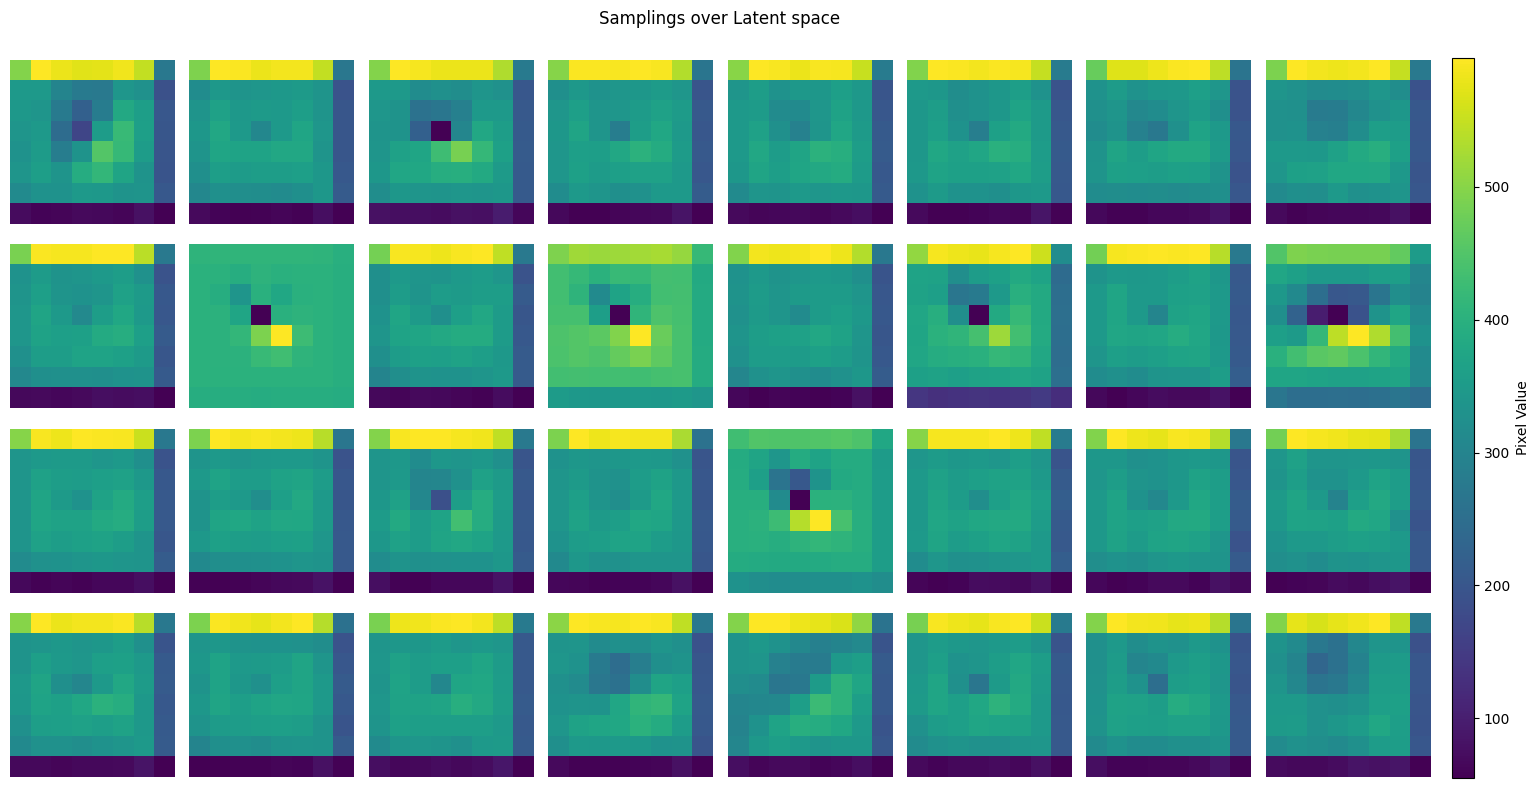

In [10]:
import matplotlib.pyplot as plt

# Plotting the original, predicted and their differences for 8 examples
num_rows, num_cols = 4, 8

plt.figure(figsize=(14.5, 8))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14.5, 8))

for ax, z_img in zip(axes.flatten(), model_bottleneck_8):
    ax.imshow(z_img)
    ax.axis("off")

# Add a title to the figure
fig.suptitle("Samplings over Latent space", fontsize=12, y=0.99)

# Adjust the layout of the subplots
fig.tight_layout()

cb_ax = fig.add_axes([1.005,.03,.015,.90])
fig.colorbar(ax.imshow(z_img),label="Pixel Value", orientation="vertical", cax=cb_ax) #,ax=axes.ravel().tolist())

# plt.savefig('Original_FR_galaxies_2.png')
# plt.close(fig)

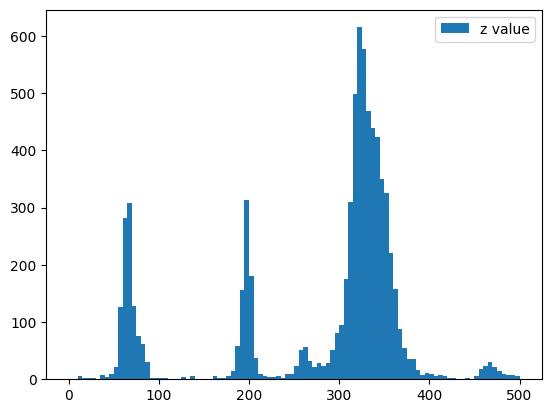

In [11]:
# Histogram of z values
plt.hist(model_bottleneck_8.flatten(),100, range=[0,500], label='z value');
plt.legend();

<Figure size 1450x800 with 0 Axes>

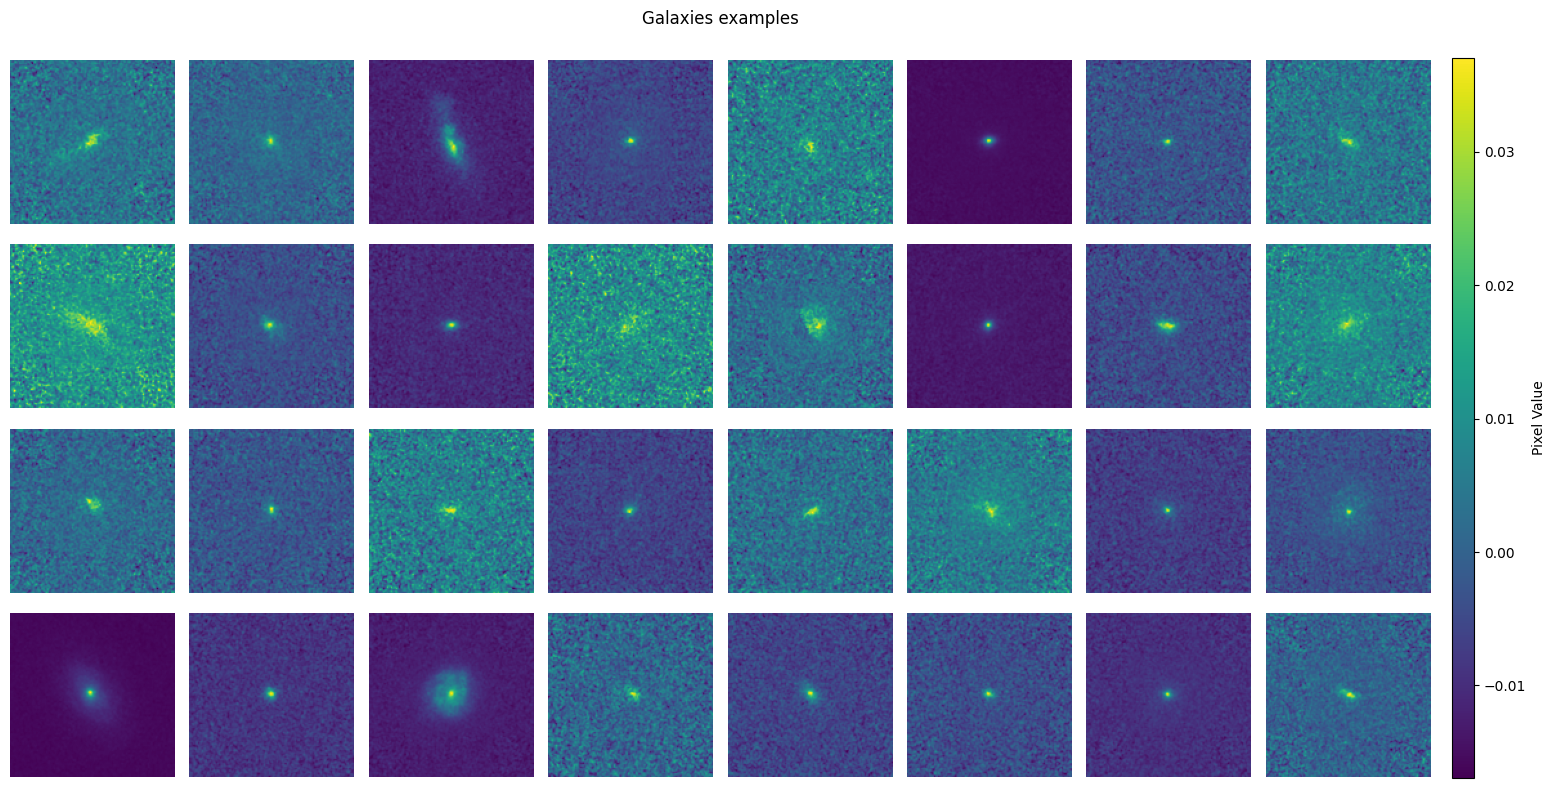

In [12]:
# Taking a bunch of images 
batch = next(dset)
x = batch['image']

# Plotting the original, predicted and their differences for 8 examples
num_rows, num_cols = 4, 8

plt.figure(figsize=(14.5, 8))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14.5, 8))

for ax, z_img in zip(axes.flatten(), x):
    ax.imshow(z_img)
    ax.axis("off")

# Add a title to the figure
fig.suptitle("Galaxies examples", fontsize=12, y=0.99)

# Adjust the layout of the subplots
fig.tight_layout()

cb_ax = fig.add_axes([1.005,.03,.015,.90])
fig.colorbar(ax.imshow(z_img),label="Pixel Value", orientation="vertical", cax=cb_ax) #,ax=axes.ravel().tolist())

# plt.savefig('Original_FR_galaxies_2.png')
# plt.close(fig)

## Normalizing Flow

In [13]:
!pip install --quiet flax

%pylab inline

import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

import tqdm
import optax
import flax.linen as nn
from flax.metrics import tensorboard

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/local/home/jt275011/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['info', 'std', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [14]:
class AffineCoupling(nn.Module):
  
  @nn.compact
  def __call__(self, x, nunits):
    
    net = nn.gelu(nn.Dense(512)(x))
    net = nn.gelu(nn.Dense(512)(net))

    # Shift and scale parameters
    shift = nn.Dense(nunits)(net)
    scale = nn.softplus(nn.Dense(nunits)(net)) + 1e-3 # For numerical stability

    return  tfb.Chain([ tfb.Shift(shift), tfb.Scale(scale)])

In [15]:
def make_nvp_fn(n_layers=4, d=64):

  # We alternate between permutations and flow layers
  layers = [ tfb.Permute(np.flip(np.arange(d)))(tfb.RealNVP(d//2, 
                                            bijector_fn=AffineCoupling(name='affine%d'%i)))
            for i in range(n_layers) ]

  # We build the actual nvp from these bijectors and a standard Gaussian distribution
  nvp = tfd.TransformedDistribution(
              tfd.MultivariateNormalDiag(loc=jnp.zeros(d), scale_diag=jnp.ones(d)),
              bijector=tfb.Chain(layers))
  return nvp

In [16]:
class NeuralSplineFlowLogProb(nn.Module):
  @nn.compact
  def __call__(self,  x):
    nvp = make_nvp_fn()
    return nvp.log_prob(x)

class NeuralSplineFlowSampler(nn.Module):
  @nn.compact
  def __call__(self,  key, n_samples):
    nvp = make_nvp_fn()
    return nvp.sample(n_samples, seed=key)

In [104]:
from galsim_jax.utils import lr_schedule

model = NeuralSplineFlowLogProb()

init_lr = 0.0001

# Random seed for initializaing network and sampling training data
seed = jax.random.PRNGKey(42)

# Initializes the weights of the model
params = model.init(seed, jnp.zeros((1,64)))

# Define a scheduler for the leaerning rate
total_steps = 100_000
lr_scheduler = optax.piecewise_constant_schedule(init_value=init_lr,
                  boundaries_and_scales={int(total_steps*0.2):0.5,
                                         int(total_steps*0.5):0.5,
                                         int(total_steps*0.75):0.5})

# Initializes an optimizer and optimizer state
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state = optimizer.init(params)

In [105]:
@jax.jit
def loss_fn(params, rng_key, batch):
    # Generating a bunch of images
    x = batch["image"]
    # Estimated posterior distribution
    q = Autoencoder3.apply(params3, x=x, seed=rng_key)
    # Get a random key for JAX
    key, rng_key = jax.random.split(rng_key)
    # Sampling over the posterior distribution
    z = q.sample(seed=key)
    # Reshaping z to the correct dimensions
    z = z.reshape([-1, 64])
    return - jnp.mean(model.apply(params, z))

@jax.jit
def update_model(params, opt_state, rng_key, batch):
    # Computes the gradients of the model
    loss, grads = jax.value_and_grad(loss_fn)(params, rng_key, batch)
    
    # Computes the weights updates and apply them
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss

In [106]:
from galsim_jax.utils import get_git_commit_version

# Login to wandb
wandb.login()

# Initializing a Weights & Biases Run
wandb.init(
    project='NF_experiments',
    name='experiment-6',
    # tags="kl_reg={:.4f}".format(reg),
)

# Setting the configs of our experiment using `wandb.config`.
# This way, Weights & Biases automatcally syncs the configs of
# our experiment which could be used to reproduce the results of an experiment.
config = wandb.config
config.seed = 42
config.batch_size = 128
# config.validation_split = 0.2
# config.pooling = "avg"
config.learning_rate = init_lr
config.steps = total_steps
config.commit_version = get_git_commit_version()
config.act_fn = nn.gelu
config.opt = 'adam'

# Define the metrics we are interested in the minimum of
wandb.define_metric("loss", summary="min")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loss,▆▂▁▁▂▂▂▂▂▂▂▁▁▂▂▄▂▂▂▄▃▃▂▂▃▃▂▃▃▃▂▂▃▄▂▂█▂▂▂


In [107]:
def min_loss(lst):
    return min(lst, key=lambda lst:lst['loss'])

In [ ]:
from galsim_jax.utils import save_checkpoint 

losses = []
start_loss = 1e30

for i in tqdm.tqdm(range(total_steps)):
  # Get a random key for JAX
  batch = next(dset)
  key, seed = jax.random.split(seed)

  # Apply the update function
  params, opt_state, loss = update_model(params, opt_state, key, batch)
  
  # Saving losses 
  losses.append({'step': i, 'loss': loss})

  if loss < start_loss:
      start_loss = loss
      save_checkpoint("checkpoint.msgpack", params, step)
    
  # Log metrics inside your training loop to visualize model performance
  wandb.log(
      {
          "loss": loss,
      },
      step=i,
  )
  
  # Periodically printing the value of the loss function, every 5000 steps
  if i %5000 ==0:
      print(
          "Step: {}, loss: {:.2f}".format(
              losses[i]['step'], losses[i]['loss'])
          )
      


In [110]:
min_loss(losses)

{'step': 5440, 'loss': Array(2.6839396e+22, dtype=float32)}

## Testing the sampler

In [111]:
sampler = NeuralSplineFlowSampler()

In [112]:
run = api.run("jonnyytorres/NF_experiments/ln90ss11")
artifact = api.artifact('jonnyytorres/NF_experiments/ln90ss11-checkpoint:best', type='model')
artifact_dir = artifact.download()

# Loading checkpoint for the best step
params = load_checkpoint("checkpoint.msgpack", params)

wandb:   1 of 1 files downloaded.  


In [113]:
samps = sampler.apply(params, jax.random.PRNGKey(1), 10000)

/local/home/jt275011/.local/lib/python3.8/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:285: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


In [114]:
samps.mean()

Array(0.00487941, dtype=float32)

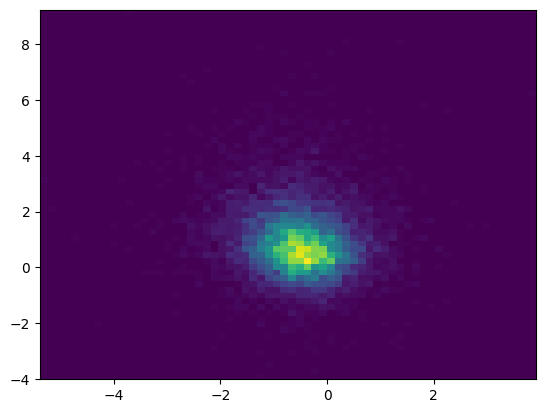

In [115]:
hist2d(samps[:,0], samps[:,1],64);

In [116]:
samps = sampler.apply(params, jax.random.PRNGKey(1), 128)

In [117]:
# Resahping to original bottleneck size
samps_r = samps.reshape(-1,8,8,1)

In [118]:
class PostQuantConv(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Conv(1, kernel_size=(1, 1), strides=(1, 1), padding="VALID")(x)

class MyModel(nn.Module):
    def setup(self):
        self.post_quant_conv = PostQuantConv()

    def __call__(self, x):
        # You can apply the post_quant_conv module like this:
        return self.post_quant_conv(x)

# Create an instance of your model
model = MyModel()

# Initialize the model with random parameters
key = jax.random.PRNGKey(0)
x = jnp.ones((1,8,8,1))  # Example input data
params_s = model.init(key, x)

# Apply the model to your input data
output = model.apply(params_s, samps_r)

In [119]:
output.shape

(128, 8, 8, 1)

In [120]:
from galsim_jax.dif_models import Decoder

# Generating a random key for JAX
rng, rng_2 = jax.random.PRNGKey(0), jax.random.PRNGKey(1)
# Size of the input to initialize the encoder parameters
batch_autoenc = jnp.ones((1, 8, 8, 1))

latent_dim = 128
act_fn = nn.gelu

# Initializing the AutoEncoder
Decoder = Decoder(
    ch_mult=(1, 2, 4, 8, 16),
    num_res_blocks=2,
    double_z=True,
    z_channels=1,
    resolution=latent_dim,
    in_channels=1,
    out_ch=1,
    ch=1,
    act_fn=act_fn,
)

params_Dec = Decoder.init(rng, z=batch_autoenc)

Working with z of shape (1, 1, 8, 8) = 64 dimensions.


In [121]:
results_nf = Decoder.apply(params_Dec, samps_r)

Working with z of shape (1, 1, 8, 8) = 64 dimensions.


In [122]:
results_nf[...,-1].shape

(128, 128, 128)

In [123]:
p = jax.vmap(convolve_kpsf)(results_nf[...,-1], kpsf[..., 0])

p = tf.expand_dims(p, axis=-1)

p = tfd.MultivariateNormalDiag(loc=p, scale_diag=[0.01])

z = p.sample(seed=rng_1)

<Figure size 1450x800 with 0 Axes>

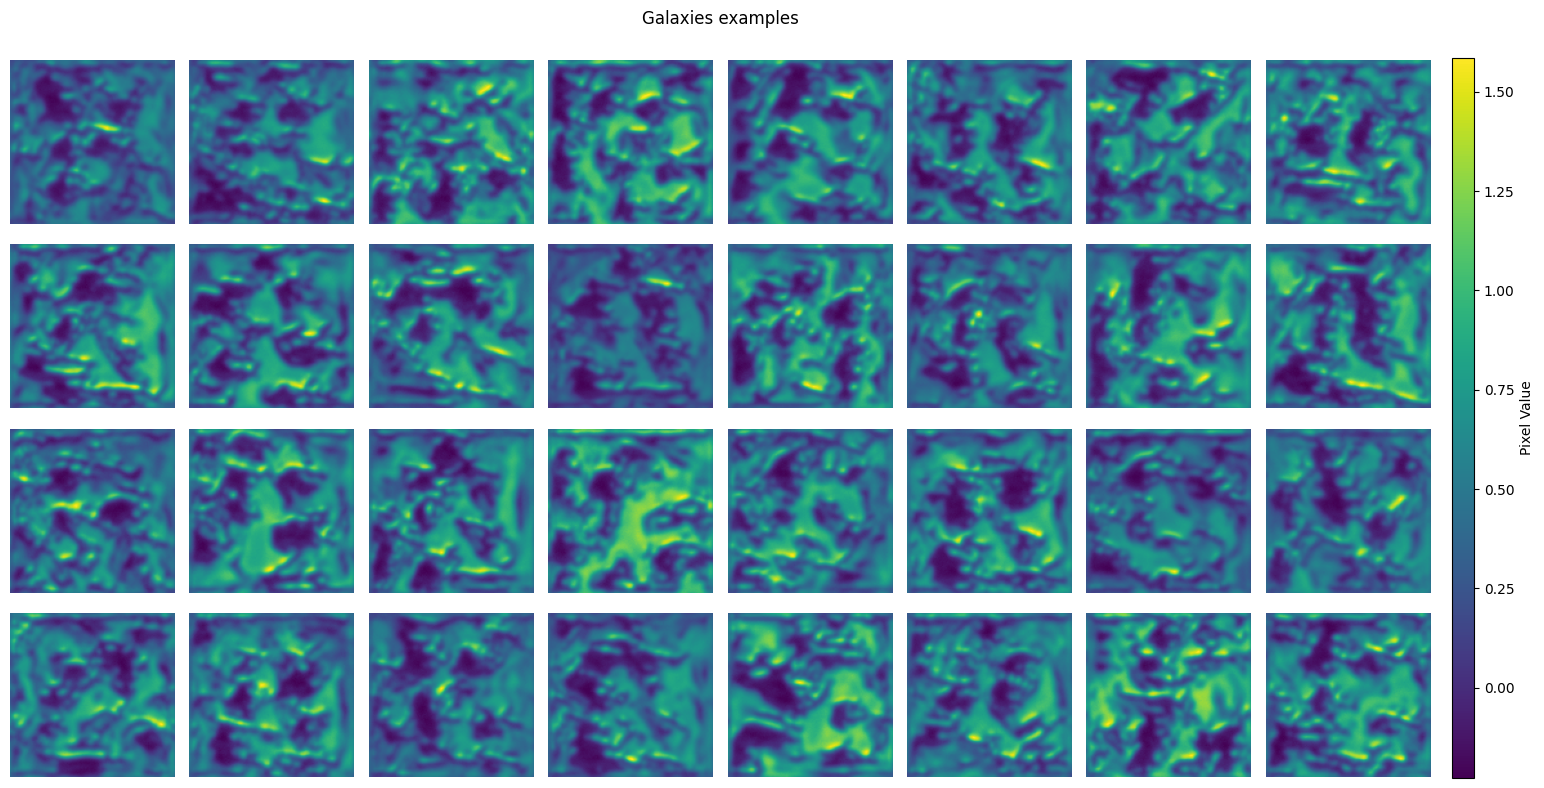

In [124]:
# Plotting the original, predicted and their differences for 8 examples
num_rows, num_cols = 4, 8

plt.figure(figsize=(14.5, 8))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14.5, 8))

for ax, z_img in zip(axes.flatten(), z):
    ax.imshow(z_img)
    ax.axis("off")

# Add a title to the figure
fig.suptitle("Galaxies examples", fontsize=12, y=0.99)

# Adjust the layout of the subplots
fig.tight_layout()

cb_ax = fig.add_axes([1.005,.03,.015,.90])
fig.colorbar(ax.imshow(z_img),label="Pixel Value", orientation="vertical", cax=cb_ax) #,ax=axes.ravel().tolist())